## Building some simple models
This notebook trains a few baseline models for fire prediction.


### Library Imports
We start by importing the Python libraries we need (and install them on the fly if they are missing).


In [4]:
# Core dependencies for baseline models
# We use the trick of wrapping the imports in a try/except so missing packages get installed automatically.
try:
    # Attempt to import everything needed for data handling, modelling, and evaluation.
    import pandas as pd
    import numpy as np
    from pathlib import Path
    from IPython.display import display
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.neural_network import MLPClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        classification_report,
        confusion_matrix,
    )
except ModuleNotFoundError:
    # If any dependency is missing we install the essentials and then import again.
    %pip install -q pandas numpy scikit-learn
    # After installation we retry the same imports so the rest of the notebook can use them.
    import pandas as pd
    import numpy as np
    from pathlib import Path
    from IPython.display import display
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.neural_network import MLPClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        classification_report,
        confusion_matrix,
    )



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Preparing the Dataset
This cell loads the engineered dataset, checks the required columns such as `lag2` and `data_split`,
and creates NumPy arrays for the training, validation, and test periods.


In [5]:
# Load enriched dataset and create train/validation/test splits
DATA_PATH = Path('outputs/training_base_enriched_power.csv')
# The engineered dataset should already exist; stop early if it does not.
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Missing dataset: {DATA_PATH}')

# Read the full dataset and make sure every expected column is available.
df = pd.read_csv(DATA_PATH)
required_columns = {
    'cell_id',
    'month',
    'fire_occurred',
    'temp2m_mean_c',
    'precip_sum_mm',
    'fire_last_month',
    'lag2',
    'data_split',
}

# These next 3 lines are a gpt trick to show all missing columns in the error message.
missing_columns = required_columns.difference(df.columns)
if missing_columns:
    raise KeyError(f'Missing expected columns: {sorted(missing_columns)}')

# Convert the month string into an actual timestamp format, and then we reorder the dataset by cell and time.
df['month_dt'] = pd.to_datetime(df['month'])
df = df.sort_values(['cell_id', 'month_dt']).reset_index(drop=True)

# We give a name to the feature of our model.
feature_columns = ['temp2m_mean_c', 'precip_sum_mm', 'fire_last_month', 'lag2']
# Empty placeholders avoid shape issues if any split is missing rows.
empty_features = np.empty((0, len(feature_columns)), dtype=float)
empty_targets = np.empty((0,), dtype=int)

split_frames = {}
for split in ['train', 'validation', 'test']:
    # defines a copy of the dataframe for each split, i.e. a variable that contains 
    # only the rows for that split.
    split_df = df[df['data_split'] == split].copy()
    # For safety, we record the empty split and warn the user so later code can skip it safely.
    if split_df.empty:
        print(f'Warning: {split} split is empty; downstream metrics may be skipped.')
        split_frames[split] = {'df': split_df, 'X': empty_features.copy(), 'y': empty_targets.copy()}
        continue

    # Replace missing feature values with 0 and store tidy NumPy copies for modelling.
    split_df.loc[:, feature_columns] = split_df[feature_columns].fillna(0)
    split_frames[split] = {
        'df': split_df,
        'X': split_df[feature_columns].to_numpy(dtype=float), #We transform the features into a numpy array because sklearn works with numpy arrays
        'y': split_df['fire_occurred'].astype(int).to_numpy(),
    }

# Training and test splits must contain data or the rest of the notebook cannot proceed. As a good practise, we 
# check it here and stop early if either is empty.
if split_frames['train']['df'].empty:
    raise RuntimeError('Training split is empty; rerun feature engineering to populate data_split.')
if split_frames['test']['df'].empty:
    raise RuntimeError('Test split is empty; rerun feature engineering to populate data_split.')

# Keep convenient copies of the pandas DataFrames for later inspection/plots.
train_df = split_frames['train']['df']
validation_df = split_frames['validation']['df']
test_df = split_frames['test']['df']

# NumPy arrays feed directly into scikit-learn estimators.
X_train = split_frames['train']['X']
y_train = split_frames['train']['y']
X_val = split_frames['validation']['X']
y_val = split_frames['validation']['y']
X_test = split_frames['test']['X']
y_test = split_frames['test']['y']

# Collect the evaluation arrays so the helper function can loop through them later.
evaluation_sets = {}
for name in ['validation', 'test']:
    split = split_frames.get(name)
    if split and split['X'].size:
        evaluation_sets[name] = (split['X'], split['y'])

# Print a summary so we have an overview of how much data lives in each time period.
for name, frame in [('train', train_df), ('validation', validation_df), ('test', test_df)]:
    rows = len(frame)
    months = frame['month'].nunique() if not frame.empty else 0
    print(f"{name.title()} rows: {rows:,} across {months} months")

print('Features:', feature_columns)

# Store tuned thresholds (one per model) so later cells can reuse them in the case we don't want to use the default 0.5.
model_thresholds = {}



Train rows: 142,185 across 30 months
Validation rows: 26,500 across 6 months
Test rows: 52,481 across 13 months
Features: ['temp2m_mean_c', 'precip_sum_mm', 'fire_last_month', 'lag2']


### Fitting the models
The ```evaluate_model``` function fits a model, optionally tunes a probability threshold on the validation split,
and reports metrics for each split.


In [6]:
# Shared evaluation helper
def evaluate_model(name, model, X_train, y_train, *args, tune_threshold=True):
    if X_train.size == 0:
        raise RuntimeError('Training split has no rows; cannot train model.')

    # Backwards-compatible argument handling lets older calls keep working.
    evaluation_sets = {}
    remaining = list(args)

    if remaining:
        first = remaining.pop(0)
        if isinstance(first, dict):
            evaluation_sets.update(first)
        else:
            if not remaining:
                raise TypeError('Expected y_test when passing X_test explicitly.')
            X_test_arg = first
            y_test_arg = remaining.pop(0)
            evaluation_sets['test'] = (X_test_arg, y_test_arg)
            if remaining and isinstance(remaining[0], dict):
                evaluation_sets.update(remaining.pop(0))

    if not evaluation_sets:
        evaluation_sets = {}

    # Fit the estimator on the training data before measuring performance.
    model.fit(X_train, y_train)
    metrics = []

    supports_proba = hasattr(model, 'predict_proba')
    chosen_threshold = 0.5

    # Optionally tune the prediction threshold using the validation split to improve F1.
    if tune_threshold and supports_proba and 'validation' in evaluation_sets:
        X_val, y_val = evaluation_sets['validation']
        if X_val.size:
            # We blend evenly spaced thresholds with actual score values to cover many possibilities.
            val_scores = model.predict_proba(X_val)[:, 1]
            candidate_thresholds = np.unique(
                np.concatenate([
                    np.linspace(0.1, 0.9, 17),
                    val_scores,
                    [0.5],
                ])
            )
            best_f1 = -1.0
            best_threshold = 0.5
            for thr in candidate_thresholds:
                preds = (val_scores >= thr).astype(int)
                score = f1_score(y_val, preds, zero_division=0)
                # Prefer improvements, and if scores tie choose the threshold closest to the default 0.5.
                if score > best_f1 or (np.isclose(score, best_f1) and abs(thr - 0.5) < abs(best_threshold - 0.5)):
                    best_f1 = score
                    best_threshold = float(thr)
            chosen_threshold = round(best_threshold, 4)
            if 'model_thresholds' in globals():
                model_thresholds[name] = chosen_threshold
    elif 'model_thresholds' in globals() and name in model_thresholds:
        chosen_threshold = model_thresholds[name]

    # Evaluate on every available split and collect the metrics in a list of dicts.
    for split_name, (X_eval, y_eval) in evaluation_sets.items():
        if X_eval.size == 0:
            print(f"{name} skipped {split_name} evaluation (empty split).")
            continue

        if supports_proba:
            scores = model.predict_proba(X_eval)[:, 1]
            preds = (scores >= chosen_threshold).astype(int)
        else:
            scores = None
            preds = model.predict(X_eval)

        metrics.append({
            'model': name,
            'split': split_name,
            'threshold': chosen_threshold if supports_proba else float('nan'),
            'accuracy': accuracy_score(y_eval, preds),
            'precision': precision_score(y_eval, preds, zero_division=0),
            'recall': recall_score(y_eval, preds, zero_division=0),
            'f1': f1_score(y_eval, preds, zero_division=0),
        })

        print(f"{name} performance on {split_name} split (threshold={chosen_threshold:.2f}):")
        print(classification_report(y_eval, preds, digits=3, zero_division=0))
        cm = confusion_matrix(y_eval, preds)
        print('Confusion matrix:', cm)

    # Return both the collected metrics and the fitted model so callers can reuse it.
    return metrics, model

# Global containers reused by subsequent cells.
results = []
trained_models = {}



### Logistic Regression Pipeline
This section standardises the features and trains a logistic regression model.


In [7]:
# Logistic regression (scaled)
# Build a Pipeline so scaling and the logistic regression model run together during training.
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs',
    )),
])

# Train, evaluate, and save the fitted model plus its metrics.
log_metrics, trained_log_reg = evaluate_model('Logistic Regression', log_reg_pipeline, X_train, y_train, evaluation_sets)
results.extend(log_metrics)
trained_models['Logistic Regression'] = trained_log_reg

if X_test.size:
    # Store logistic predictions so we can visualise them later just like the neural network outputs.
    log_reg_threshold = model_thresholds.get('Logistic Regression', 0.5)
    log_reg_scores = trained_log_reg.predict_proba(X_test)[:, 1]
    test_df.loc[:, 'log_reg_pred'] = (log_reg_scores >= log_reg_threshold).astype(int)



Logistic Regression performance on validation split (threshold=0.61):
              precision    recall  f1-score   support

           0      0.950     0.934     0.942     18809
           1      0.846     0.880     0.863      7691

    accuracy                          0.919     26500
   macro avg      0.898     0.907     0.902     26500
weighted avg      0.920     0.919     0.919     26500

Confusion matrix: [[17573  1236]
 [  920  6771]]
Logistic Regression performance on test split (threshold=0.61):
              precision    recall  f1-score   support

           0      0.938     0.950     0.944     41433
           1      0.804     0.764     0.783     11048

    accuracy                          0.911     52481
   macro avg      0.871     0.857     0.864     52481
weighted avg      0.910     0.911     0.910     52481

Confusion matrix: [[39372  2061]
 [ 2611  8437]]


### Neural Network Pipeline
Here we build a simple neural network classifier, evaluate it, and keep its predictions for later visualisations.


In [8]:
# Feed-forward neural network (MLPClassifier)
# The neural network also sits inside a Pipeline so inputs are scaled consistently.
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        random_state=42,
        max_iter=500,
        early_stopping=True,
        n_iter_no_change=10,
    )),
])

mlp_metrics, trained_mlp = evaluate_model('Neural Network (MLP)', mlp_pipeline, X_train, y_train, evaluation_sets)
results.extend(mlp_metrics)
trained_models['Neural Network (MLP)'] = trained_mlp

if X_test.size:
    # Convert the neural network probabilities into binary predictions using the tuned threshold.
    mlp_threshold = model_thresholds.get('Neural Network (MLP)', 0.5)
    mlp_scores = trained_mlp.predict_proba(X_test)[:, 1]
    test_df.loc[:, 'mlp_pred'] = (mlp_scores >= mlp_threshold).astype(int)



Neural Network (MLP) performance on validation split (threshold=0.54):
              precision    recall  f1-score   support

           0      0.945     0.942     0.944     18809
           1      0.859     0.866     0.863      7691

    accuracy                          0.920     26500
   macro avg      0.902     0.904     0.903     26500
weighted avg      0.920     0.920     0.920     26500

Confusion matrix: [[17720  1089]
 [ 1032  6659]]
Neural Network (MLP) performance on test split (threshold=0.54):
              precision    recall  f1-score   support

           0      0.933     0.955     0.944     41433
           1      0.814     0.742     0.776     11048

    accuracy                          0.910     52481
   macro avg      0.873     0.848     0.860     52481
weighted avg      0.908     0.910     0.908     52481

Confusion matrix: [[39558  1875]
 [ 2853  8195]]


### Random Forest Baseline
This block trains a tree-based ensemble and captures its validation/test metrics.


In [9]:
# Random forest baseline
# Configure a moderately large forest; `class_weight='balanced_subsample'` handles class imbalance.
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1,
)

rf_metrics, trained_rf = evaluate_model('Random Forest', rf_model, X_train, y_train, evaluation_sets)
results.extend(rf_metrics)
trained_models['Random Forest'] = trained_rf



Random Forest performance on validation split (threshold=0.42):
              precision    recall  f1-score   support

           0      0.932     0.933     0.933     18809
           1      0.837     0.834     0.836      7691

    accuracy                          0.905     26500
   macro avg      0.885     0.884     0.884     26500
weighted avg      0.905     0.905     0.905     26500

Confusion matrix: [[17557  1252]
 [ 1273  6418]]
Random Forest performance on test split (threshold=0.42):
              precision    recall  f1-score   support

           0      0.934     0.916     0.925     41433
           1      0.706     0.759     0.731     11048

    accuracy                          0.883     52481
   macro avg      0.820     0.837     0.828     52481
weighted avg      0.886     0.883     0.884     52481

Confusion matrix: [[37936  3497]
 [ 2665  8383]]


### Comparing Model Performance
We gather all the metrics into a single table so it is easy to compare models across splits.


### Model metrics at a glance
Styled summary of the tuned metrics so we can present them neatly.


In [11]:
if 'summary_df' not in globals():
    raise NameError('Run the metric aggregation cell before displaying the summary.')

styled = (
    summary_df.copy()
        .sort_values(['split', 'f1'], ascending=[True, False])
        .rename(columns={
            'split': 'Split',
            'threshold': 'Threshold',
            'accuracy': 'Accuracy',
            'precision': 'Precision',
            'recall': 'Recall',
            'f1': 'F1 Score'
        })
        .style
        .format({
            'Threshold': '{:.2f}',
            'Accuracy': '{:.3f}',
            'Precision': '{:.3f}',
            'Recall': '{:.3f}',
            'F1 Score': '{:.3f}'
        })
        .background_gradient(axis=0, subset=['Accuracy', 'Precision', 'Recall', 'F1 Score'], cmap='Greens')
        .set_caption('Model metrics by split with tuned thresholds')
)
styled


NameError: Run the metric aggregation cell before displaying the summary.

In [ ]:
# Aggregate metrics for easy comparison
summary_df = pd.DataFrame(results)
if summary_df.empty:
    print('No evaluation metrics captured.')
else:
    # Sort and reformat so the table is easy to read at a glance.
    summary_df = summary_df.sort_values(['split', 'f1'], ascending=[True, False])
    display_cols = ['threshold', 'accuracy', 'precision', 'recall', 'f1']
    missing_cols = [c for c in display_cols if c not in summary_df.columns]
    for col in missing_cols:
        summary_df[col] = np.nan
    summary_df = summary_df[['model', 'split'] + display_cols]
    summary_df = summary_df.set_index(['model', 'split'])
    print('Summary metrics by split (thresholds tuned on validation when available):')
    display(summary_df.style.format({
        'threshold': '{:.2f}',
        'accuracy': '{:.3f}',
        'precision': '{:.3f}',
        'recall': '{:.3f}',
        'f1': '{:.3f}',
    }, na_rep='—'))



Summary metrics by split (thresholds tuned on validation when available):


,,threshold,accuracy,precision,recall,f1
model,split,,,,,
Logistic Regression,test,0.61,0.911,0.804,0.764,0.783
Neural Network (MLP),test,0.54,0.910,0.814,0.742,0.776
Random Forest,test,0.42,0.883,0.706,0.759,0.731
Logistic Regression,validation,0.61,0.919,0.846,0.880,0.863
Neural Network (MLP),validation,0.54,0.920,0.859,0.866,0.863
Random Forest,validation,0.42,0.905,0.837,0.834,0.836


### Monthly Prediction Plot
This figure shows how each trained model's predicted probabilities line up with the actual fire rate over time.


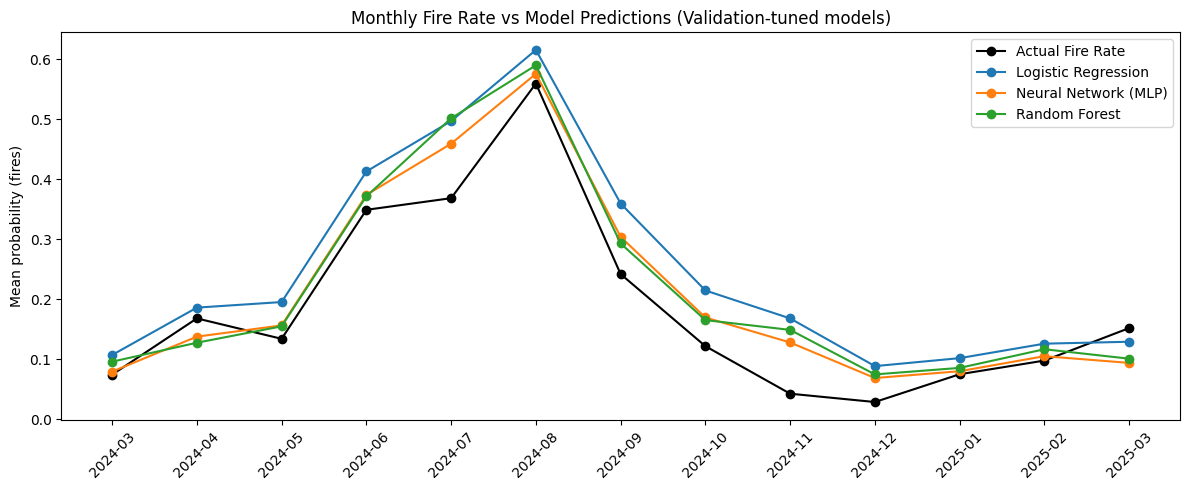

In [ ]:
# Plot model prediction probabilities vs actual fire rate by month
import matplotlib.pyplot as plt

# Ensure we have test data to plot; otherwise the chart would be meaningless.
test_entry = evaluation_sets.get('test')
if not test_entry or test_entry[0].size == 0:
    raise RuntimeError('Test split is empty; rerun the data preparation cell before plotting.')

plot_df = test_df[['month_dt', 'fire_occurred']].copy()
plot_df['month_label'] = plot_df['month_dt'].dt.to_period('M').astype(str)
monthly_summary = plot_df.groupby('month_label', as_index=False).agg(actual_fires=('fire_occurred', 'mean'))

models_for_plot = [
    ('Logistic Regression', trained_models.get('Logistic Regression')),
    ('Neural Network (MLP)', trained_models.get('Neural Network (MLP)')),
    ('Random Forest', trained_models.get('Random Forest')),
]

# Only keep models that actually ran so we do not try to plot missing results.
models_for_plot = [(name, model) for name, model in models_for_plot if model is not None]

for name, model in models_for_plot:
    # Probability outputs give smoother curves; fall back to predictions for models without predict_proba.
    if hasattr(model, 'predict_proba'):
        scores = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.predict(X_test)
    tmp = pd.DataFrame({
        'month_label': test_df['month_dt'].dt.to_period('M').astype(str).values,
        name: scores,
    })
    tmp = tmp.groupby('month_label', as_index=False).mean()
    monthly_summary = monthly_summary.merge(tmp, on='month_label', how='left')

plt.figure(figsize=(12, 5))
plt.plot(monthly_summary['month_label'], monthly_summary['actual_fires'], marker='o', label='Actual Fire Rate', color='black')
for name, _ in models_for_plot:
    plt.plot(monthly_summary['month_label'], monthly_summary[name], marker='o', label=name)

plt.xticks(rotation=45)
plt.ylabel('Mean probability (fires)')
plt.title('Monthly Fire Rate vs Model Predictions (Validation-tuned models)')
plt.legend()
plt.tight_layout()
plt.show()



### Animated Map
Finally, we create a side-by-side animation that compares actual fires with the neural network's predictions.


In [ ]:
# Neural network predictions vs actual fires (side-by-side GIF)
try:
    import geopandas as gpd
except ModuleNotFoundError:
    %pip install -q geopandas
    import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from shapely import affinity

base_grid_path = Path('data/processed/training_base.geojson')
if not base_grid_path.exists():
    raise FileNotFoundError(f'Missing grid file: {base_grid_path}')

# Double-check that all prerequisites are ready before we generate frames.
if test_df.empty:
    raise RuntimeError('Test split is empty; rerun the modelling cells before generating the GIF.')

mlp_model = trained_models.get('Neural Network (MLP)')
if mlp_model is None:
    raise RuntimeError('Missing trained MLP model; rerun the neural network cell first.')

if 'mlp_pred' not in test_df.columns:
    if 'X_test' not in globals() or X_test.size == 0:
        raise RuntimeError('Test feature matrix unavailable; rerun the data split cell before drawing the GIF.')
    mlp_threshold = model_thresholds.get('Neural Network (MLP)', 0.5)
    mlp_scores = mlp_model.predict_proba(X_test)[:, 1]
    test_df = test_df.copy()
    test_df.loc[:, 'mlp_pred'] = (mlp_scores >= mlp_threshold).astype(int)
else:
    test_df = test_df.copy()

base_grid = gpd.read_file(base_grid_path)[['cell_id', 'geometry']]
base_grid['cell_id'] = base_grid['cell_id'].astype(str)

test_df['cell_id'] = test_df['cell_id'].astype(str)
months = sorted(test_df['month_dt'].unique())
if not months:
    raise RuntimeError('No monthly slices available to animate.')

lon_min, lat_min, lon_max, lat_max = base_grid.total_bounds

monthly_layers = {}
for month in months:
    month_slice = test_df[test_df['month_dt'] == month]
    summary = month_slice.groupby('cell_id')[['fire_occurred', 'mlp_pred']].max().reset_index()
    month_grid = base_grid.merge(summary, on='cell_id', how='left')
    # Fill missing values with zeros so the plotting code can treat them as "no fire" cells.
    month_grid[['fire_occurred', 'mlp_pred']] = month_grid[['fire_occurred', 'mlp_pred']].fillna(0).astype(int)
    monthly_layers[month] = month_grid

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
actual_color = '#d62728'
pred_color = '#1f77b4'
shrink_factor = 0.65

for ax in axes:
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', linewidth=0.4, color='#dddddd', alpha=0.8)

def _draw_panel(ax, month_grid, column, title, color):
    ax.clear()
    base_grid.plot(ax=ax, edgecolor='lightgrey', facecolor='none', linewidth=0.25)
    active = month_grid[month_grid[column] == 1]
    if not active.empty:
        # Shrink the coloured squares slightly so the grid lines stay visible.
        shrunk = active.copy()
        shrunk['geometry'] = shrunk.geometry.apply(lambda geom: affinity.scale(geom, xfact=shrink_factor, yfact=shrink_factor, origin='centroid'))
        shrunk.plot(ax=ax, facecolor=color, edgecolor='#333333', linewidth=0.15, alpha=0.9)
    ax.set_title(title)
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', linewidth=0.4, color='#dddddd', alpha=0.8)

annotation = fig.suptitle('')
count_text = fig.text(0.5, 0.04, '', ha='center', fontsize=10, color='#333333')

frames = []
for idx, month in enumerate(months, start=1):
    month_grid = monthly_layers[month]
    label = pd.Timestamp(month).strftime('%Y-%m')
    _draw_panel(axes[0], month_grid, 'fire_occurred', 'Actual fires', actual_color)
    _draw_panel(axes[1], month_grid, 'mlp_pred', 'NN predicted fires', pred_color)
    annotation.set_text(f'Month: {label}')
    counts = (int(month_grid['fire_occurred'].sum()), int(month_grid['mlp_pred'].sum()))
    count_text.set_text(f'Cells w/ fire: {counts[0]}    |    Cells predicted: {counts[1]}')

    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)

    if idx % 3 == 0 or idx == len(months):
        print(f'Rendered {idx}/{len(months)} months', flush=True)

plt.close(fig)

# Export the animation so it can be shared outside the notebook.
gif_out = Path('outputs/squares_nn_actual_vs_pred.gif')
gif_out.parent.mkdir(parents=True, exist_ok=True)
imageio.mimsave(gif_out, frames, fps=1)
print('Saved neural network actual vs predicted GIF →', gif_out)



/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Rendered 3/13 months


/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Rendered 6/13 months


/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Rendered 9/13 months


/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Rendered 12/13 months


/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Rendered 13/13 months


/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/4116267271.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Saved neural network actual vs predicted GIF → outputs/squares_nn_actual_vs_pred.gif


In [ ]:
# Logistic regression predictions vs actual fires (side-by-side GIF)
try:
    import geopandas as gpd
except ModuleNotFoundError:
    %pip install -q geopandas
    import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from shapely import affinity

base_grid_path = Path('data/processed/training_base.geojson')
if not base_grid_path.exists():
    raise FileNotFoundError(f'Missing grid file: {base_grid_path}')

if test_df.empty:
    raise RuntimeError('Test split is empty; rerun the modelling cells before generating the GIF.')

log_model = trained_models.get('Logistic Regression')
if log_model is None:
    raise RuntimeError('Missing trained logistic regression model; rerun the logistic cell first.')

if 'log_reg_pred' not in test_df.columns:
    if 'X_test' not in globals() or X_test.size == 0:
        raise RuntimeError('Test feature matrix unavailable; rerun the data split cell before drawing the GIF.')
    log_threshold = model_thresholds.get('Logistic Regression', 0.5)
    log_scores = log_model.predict_proba(X_test)[:, 1]
    test_df = test_df.copy()
    test_df.loc[:, 'log_reg_pred'] = (log_scores >= log_threshold).astype(int)
else:
    test_df = test_df.copy()

base_grid = gpd.read_file(base_grid_path)[['cell_id', 'geometry']]
base_grid['cell_id'] = base_grid['cell_id'].astype(str)

test_df['cell_id'] = test_df['cell_id'].astype(str)
months = sorted(test_df['month_dt'].unique())
if not months:
    raise RuntimeError('No monthly slices available to animate.')

lon_min, lat_min, lon_max, lat_max = base_grid.total_bounds

monthly_layers = {}
for month in months:
    month_slice = test_df[test_df['month_dt'] == month]
    summary = month_slice.groupby('cell_id')[['fire_occurred', 'log_reg_pred']].max().reset_index()
    month_grid = base_grid.merge(summary, on='cell_id', how='left')
    month_grid[['fire_occurred', 'log_reg_pred']] = month_grid[['fire_occurred', 'log_reg_pred']].fillna(0).astype(int)
    monthly_layers[month] = month_grid

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
actual_color = '#d62728'
pred_color = '#ff7f0e'
shrink_factor = 0.65

for ax in axes:
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', linewidth=0.4, color='#dddddd', alpha=0.8)

def _draw_panel(ax, month_grid, column, title, color):
    ax.clear()
    base_grid.plot(ax=ax, edgecolor='lightgrey', facecolor='none', linewidth=0.25)
    active = month_grid[month_grid[column] == 1]
    if not active.empty:
        shrunk = active.copy()
        shrunk['geometry'] = shrunk.geometry.apply(lambda geom: affinity.scale(geom, xfact=shrink_factor, yfact=shrink_factor, origin='centroid'))
        shrunk.plot(ax=ax, facecolor=color, edgecolor='#333333', linewidth=0.15, alpha=0.9)
    ax.set_title(title)
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', linewidth=0.4, color='#dddddd', alpha=0.8)

annotation = fig.suptitle('')
count_text = fig.text(0.5, 0.04, '', ha='center', fontsize=10, color='#333333')

frames = []
for idx, month in enumerate(months, start=1):
    month_grid = monthly_layers[month]
    label = pd.Timestamp(month).strftime('%Y-%m')
    _draw_panel(axes[0], month_grid, 'fire_occurred', 'Actual fires', actual_color)
    _draw_panel(axes[1], month_grid, 'log_reg_pred', 'Logistic predicted fires', pred_color)
    annotation.set_text(f'Month: {label}')
    counts = (int(month_grid['fire_occurred'].sum()), int(month_grid['log_reg_pred'].sum()))
    count_text.set_text(f'Cells w/ fire: {counts[0]}    |    Cells predicted: {counts[1]}')

    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)

    if idx % 3 == 0 or idx == len(months):
        print(f'Rendered {idx}/{len(months)} months', flush=True)

plt.close(fig)

log_gif_out = Path('outputs/squares_log_reg_actual_vs_pred.gif')
log_gif_out.parent.mkdir(parents=True, exist_ok=True)
imageio.mimsave(log_gif_out, frames, fps=1)
print('Saved logistic regression actual vs predicted GIF →', log_gif_out)



/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Rendered 3/13 months


/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Rendered 6/13 months


/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Rendered 9/13 months


/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Rendered 12/13 months


/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Rendered 13/13 months


/var/folders/47/y48y4chs6n5bf9f7rg1d0sjw004z89/T/ipykernel_92230/3183653417.py:92: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Saved logistic regression actual vs predicted GIF → outputs/squares_log_reg_actual_vs_pred.gif
